# Classifier

### Imports

In [1]:
file_path = 'dataset.csv'

### I. Preprocessing
Tokenize each line in the dataset into words, ignore punctuation

In [41]:
import csv
import re


def tokenize_text(text):
    # Convert sentences to words
    words = text.lower().split()
    
    # Removing unnecessary punctuation and tags
    words = [re.sub(r"[^a-zA-Z0-9]", "", word) for word in words]
    
    # Removing stop words
    stop_words = set(['the', 'is', 'are', 'and', 'that', 'do', 'have'])
    words = [word for word in words if word not in stop_words]
    
    # Stemming (using a simple stemming rule)
    words = [word[:-1] if word.endswith('s') else word for word in words]
    
    return words


def tokenize_csv(file_path, type, cutt_off):
    tokenized_data = []
    
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        
        for i, row in enumerate(reader):
            if type == 'train' and i >= cutt_off:
                continue

            if type == 'test' and i < cutt_off:
                continue
            
            tokenized_row = {}
            
            # Tokenize the 'text' column
            tokenized_text = tokenize_text(row['text'])
            tokenized_row['text'] = tokenized_text
            
            # Preserve the 'type' column as is
            tokenized_row['type'] = row['type']
            
            tokenized_data.append(tokenized_row)
    
    return tokenized_data


### II. Model and Training
Split the data (consisting of 5559 messages) and train the model on the 5000 of the data

In [42]:
cutt_off = 5000

In [43]:
from collections import Counter

def fit(training_data, cutt_off):
    
    spam, ham = [], []
    total_spam_messages, total_ham_messages = 0, 0
    
    for message in training_data:
        text, type = message['text'], message['type']
        
        if type == 'spam':
            spam.extend(text)
            total_spam_messages += 1
        else:
            ham.extend(text)
            total_ham_messages += 1
    
    total_words_in_ham = len(ham)
    total_words_in_spam = len(spam)
    
    count_ham = Counter(ham)
    count_spam = Counter(spam)
    
    likelyhood_ham = {word: count_ham[word] / total_words_in_ham for word in count_ham}
    likelyhood_spam = {word: count_spam[word] / total_words_in_spam for word in count_spam}
    
    probability_ham = total_ham_messages / (total_ham_messages + total_spam_messages)
    probability_spam = total_spam_messages / (total_ham_messages + total_spam_messages)
    
    return likelyhood_ham, likelyhood_spam, probability_ham, probability_spam, total_words_in_ham, total_words_in_spam

### III. Testing

#### III.I. Prediction Function
First compute:

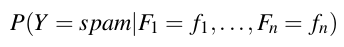

and

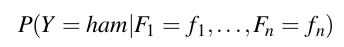

and then return which ever is higher. In short, the prediction function will implement the following formula.

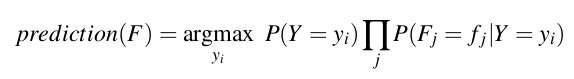

In [52]:
cutt_off = 2500
training_data = tokenize_csv(file_path, 'train', cutt_off)
likelyhood_ham, likelyhood_spam, probability_ham, probability_spam, total_words_in_ham, total_words_in_spam = fit(training_data, cutt_off)

def predict(message):
    words_given_ham = 1
    words_given_spam = 1

    for word in message:
        words_given_ham *= likelyhood_ham[word] if word in likelyhood_ham else 1 / total_words_in_ham
        words_given_spam *= likelyhood_spam[word] if word in likelyhood_spam else 1 / total_words_in_spam
    
    probability_ham_message_given_message = words_given_ham * probability_ham
    probability_spam_message_given_message = words_given_spam * probability_spam

    if probability_ham_message_given_message > probability_spam_message_given_message:
        return 'ham'
    return 'spam'


#### III.II. Moment of Truth

In [53]:
testing_data = tokenize_csv(file_path, 'test', cutt_off)

count_correct = 0
count_incorrect = 0

for message in testing_data:
    if predict(message['text']) == message['type']:
        count_correct += 1
    else:
        count_incorrect += 1

print("Accuracy:", str(round(count_correct / (count_correct + count_incorrect), 5) * 100) + "%")

Accuracy: 92.48100000000001%
